In [1]:
import psycopg2
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt

from config import DB_VISION_ZERO, DB_MOPED

In [2]:
def get_data(query, cursor):
    """
    Get data from database
    """
    cursor.execute(query)
    data = cursor.fetchall()
    field_names = [i[0] for i in cursor.description]
    df = pd.DataFrame(data, columns=field_names)

    return df

conn_vz = psycopg2.connect(
    dbname = DB_VISION_ZERO['dbname'],
    user = DB_VISION_ZERO["user"],
    host = DB_VISION_ZERO["host"],
    password = DB_VISION_ZERO["password"],
    port=5432
)

conn_moped = psycopg2.connect(
    dbname = DB_MOPED["dbname"],
    user = DB_MOPED["user"],
    host = DB_MOPED["host"],
    password = DB_MOPED["password"],
    port = 5432
)

cursor_vz = conn_vz.cursor()
cursor_moped = conn_moped.cursor()

# Moped processing

In [484]:
# Creating moped dataframe
QUERY_MOPED = """SELECT project_id, project_component_id, geometry, 
line_geometry, substantial_completion_date, 
substantial_completion_date_estimated, completion_date, completion_end_date,
component_name FROM component_arcgis_online_view"""

# Creating moped dataframe
df_moped = get_data(QUERY_MOPED, cursor_moped)
df_moped.to_csv('df_moped.csv')  

In [485]:
# Data frame info
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12179 entries, 0 to 12178
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12179 non-null  int64              
 1   project_component_id                   11731 non-null  float64            
 2   geometry                               11731 non-null  object             
 3   line_geometry                          11731 non-null  object             
 4   substantial_completion_date            2866 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  394 non-null    datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    268 non-null    datetime64[ns, UTC]
 8   component_name                         12179 non-null  object             
dtypes: date

In [486]:
# Dropping observations where completion end date is not present
df_moped_filter = df_moped.dropna(subset=['substantial_completion_date'])
df_moped_filter.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name
10,12,181.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
11,12,183.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
12,12,182.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
13,12,469.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Intersection
14,12,16.0,"{'type': 'MultiPoint', 'coordinates': [[-97.73...","{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal


In [487]:
df_moped_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2866 entries, 10 to 12167
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2866 non-null   int64              
 1   project_component_id                   2683 non-null   float64            
 2   geometry                               2683 non-null   object             
 3   line_geometry                          2683 non-null   object             
 4   substantial_completion_date            2866 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    193 non-null    datetime64[ns, UTC]
 8   component_name                         2866 non-null   object             
dtypes: datetime6

In [488]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["substantial_completion_date",
                     "substantial_completion_date_estimated", 
                     "completion_date", 
                     "completion_end_date"]

for col in timestamp_columns:
    df_moped_filter.loc[:, col] = df_moped_filter[col].astype(str)

# Apply the geometry transformation using .loc
df_moped_filter.loc[:, "geometry"] = df_moped_filter["geometry"].apply(lambda x: shape(x) if x is not None else None)

# Create GeoDataFrame
gdf_moped = gpd.GeoDataFrame(df_moped_filter, geometry="geometry")

In [489]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
12,12,182.0,MULTIPOINT (-97.73386 30.26657),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
13,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Intersection
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal


In [490]:
df_moped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12179 entries, 0 to 12178
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             12179 non-null  int64              
 1   project_component_id                   11731 non-null  float64            
 2   geometry                               11731 non-null  object             
 3   line_geometry                          11731 non-null  object             
 4   substantial_completion_date            2866 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  394 non-null    datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    268 non-null    datetime64[ns, UTC]
 8   component_name                         12179 non-null  object             
dtypes: date

In [491]:
df_moped_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2866 entries, 10 to 12167
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2866 non-null   int64              
 1   project_component_id                   2683 non-null   float64            
 2   geometry                               2683 non-null   object             
 3   line_geometry                          2683 non-null   object             
 4   substantial_completion_date            2866 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    193 non-null    datetime64[ns, UTC]
 8   component_name                         2866 non-null   object             
dtypes: datetime6

# VisionZero processing

In [492]:
# Creaing vision zero dataframe
QUERY_CRASH_DATA = """SELECT crash_id, crash_fatal_fl, crash_date, rpt_latitude,
rpt_longitude, road_constr_zone_fl, latitude, longitude, tot_injry_cnt, death_cnt, est_comp_cost 
FROM atd_txdot_crashes"""

df_vz = get_data(QUERY_CRASH_DATA, cursor_vz)
df_vz.to_csv('df_vz.csv')

In [493]:
df_vz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418679 entries, 0 to 418678
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             418679 non-null  int64  
 1   crash_fatal_fl       418679 non-null  object 
 2   crash_date           418679 non-null  object 
 3   rpt_latitude         62752 non-null   float64
 4   rpt_longitude        62752 non-null   float64
 5   road_constr_zone_fl  418675 non-null  object 
 6   latitude             387178 non-null  float64
 7   longitude            387178 non-null  float64
 8   tot_injry_cnt        418675 non-null  float64
 9   death_cnt            418676 non-null  float64
 10  est_comp_cost        418675 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 35.1+ MB


In [494]:
# Filtering

# Keepiing only those observations where x-y coordinates are present
df_vz_filter = df_vz[df_vz['latitude'].notnull() & df_vz['longitude'].notnull()]

In [495]:
df_vz_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387178 entries, 0 to 418678
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   crash_id             387178 non-null  int64  
 1   crash_fatal_fl       387178 non-null  object 
 2   crash_date           387178 non-null  object 
 3   rpt_latitude         60561 non-null   float64
 4   rpt_longitude        60561 non-null   float64
 5   road_constr_zone_fl  387178 non-null  object 
 6   latitude             387178 non-null  float64
 7   longitude            387178 non-null  float64
 8   tot_injry_cnt        387178 non-null  float64
 9   death_cnt            387178 non-null  float64
 10  est_comp_cost        387178 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 35.4+ MB


In [496]:
# Convert timestamp columns to string using .loc
timestamp_columns = ["crash_date"]

for col in timestamp_columns:
    df_vz_filter.loc[:, col] = df_vz_filter[col].astype(str)

In [497]:
# Creating geodataframe
gdf_vz = gpd.GeoDataFrame(df_vz_filter,
                          geometry=gpd.points_from_xy(df_vz_filter.longitude,
                                                      df_vz_filter.latitude),
                                                      crs='EPSG:4326')

gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,est_comp_cost,geometry
0,19933313,N,2023-12-15,NaN,NaN,N,30.521561,-97.655456,0.0,0.0,153000.00,POINT (-97.65546 30.52156)
1,19924404,N,2023-12-15,30.33031,-97.62485,N,30.330687,-97.623982,0.0,0.0,306000.00,POINT (-97.62398 30.33069)
2,19950378,N,2023-12-22,NaN,NaN,N,30.534858,-97.668046,0.0,0.0,51000.00,POINT (-97.66805 30.53486)
4,20087344,N,2024-03-14,NaN,NaN,N,30.342069,-97.967777,0.0,0.0,153000.00,POINT (-97.96778 30.34207)
6,19940966,N,2023-12-16,NaN,NaN,N,30.578759,-97.852841,0.0,0.0,204000.00,POINT (-97.85284 30.57876)


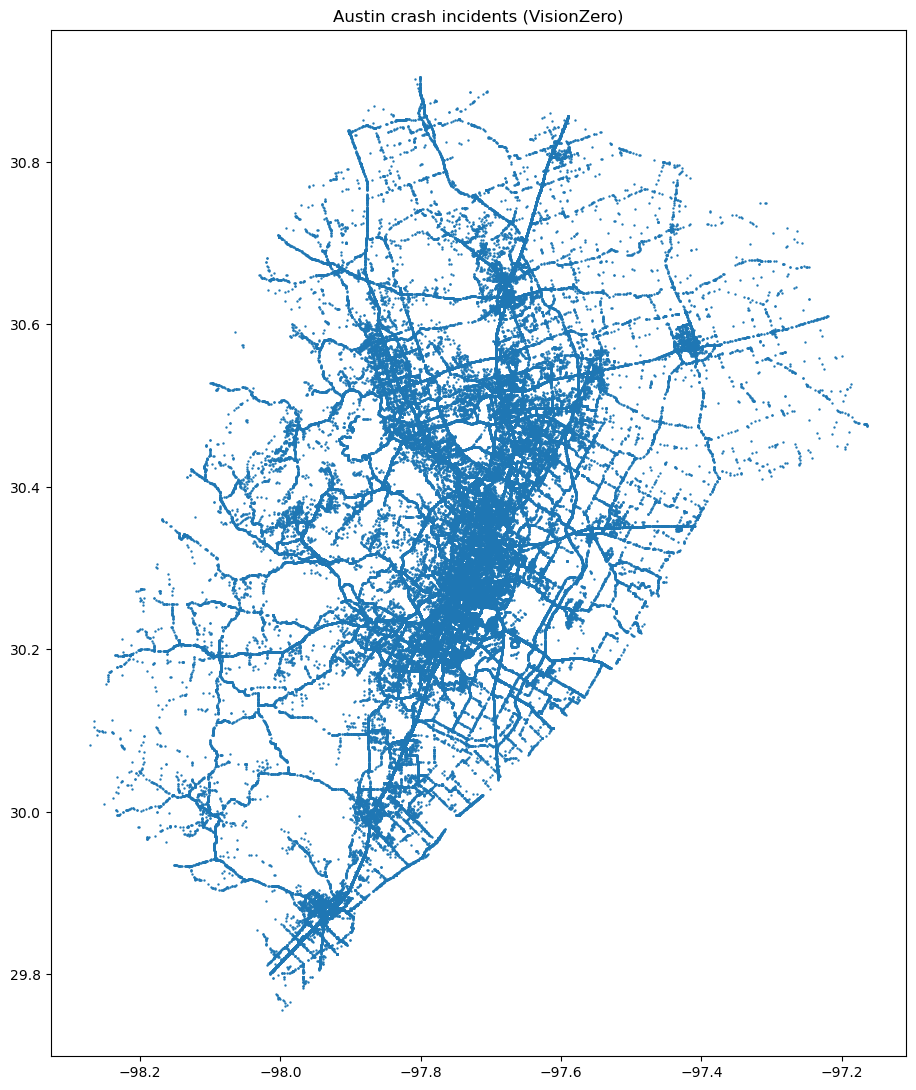

In [498]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 13.33))
gdf_vz.plot(ax=ax, markersize=0.5)  
plt.title('Austin crash incidents (VisionZero)')
plt.show()

# Spatial join

In [499]:
gdf_vz.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,est_comp_cost,geometry
0,19933313,N,2023-12-15,NaN,NaN,N,30.521561,-97.655456,0.0,0.0,153000.00,POINT (-97.65546 30.52156)
1,19924404,N,2023-12-15,30.33031,-97.62485,N,30.330687,-97.623982,0.0,0.0,306000.00,POINT (-97.62398 30.33069)
2,19950378,N,2023-12-22,NaN,NaN,N,30.534858,-97.668046,0.0,0.0,51000.00,POINT (-97.66805 30.53486)
4,20087344,N,2024-03-14,NaN,NaN,N,30.342069,-97.967777,0.0,0.0,153000.00,POINT (-97.96778 30.34207)
6,19940966,N,2023-12-16,NaN,NaN,N,30.578759,-97.852841,0.0,0.0,204000.00,POINT (-97.85284 30.57876)


In [500]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
12,12,182.0,MULTIPOINT (-97.73386 30.26657),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
13,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","{'type': 'MultiLineString', 'coordinates': [[[...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Intersection
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"{'type': 'LineString', 'coordinates': [[-97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal


In [501]:
gdf_moped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2866 entries, 10 to 12167
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   project_id                             2866 non-null   int64              
 1   project_component_id                   2683 non-null   float64            
 2   geometry                               2683 non-null   geometry           
 3   line_geometry                          2683 non-null   object             
 4   substantial_completion_date            2866 non-null   datetime64[ns, UTC]
 5   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 6   completion_date                        349 non-null    datetime64[ns, UTC]
 7   completion_end_date                    193 non-null    datetime64[ns, UTC]
 8   component_name                         2866 non-null   object             
dtypes: d

In [502]:
# Keeping only those observations where line_geometry is available
gdf_moped = gdf_moped.dropna(subset=['line_geometry'])

In [503]:
# Function to parase line_geometry column in the moped data frame
def parse_linestring(line_geom):

    if line_geom['type'] == 'LineString':
        coordinates = [tuple(coord) for coord in line_geom['coordinates']]
        return LineString(coordinates)
    elif line_geom['type'] == 'MultiLineString':
        lines = [LineString([tuple(coord) for coord in line]) for line in line_geom['coordinates']]
        return MultiLineString(lines)
    else:
        raise ValueError(f"Unexpected geometry type: {line_geom['type']}")

gdf_moped['line_geometry'] = gdf_moped['line_geometry'].apply(parse_linestring)

In [504]:
gdf_moped.head()

,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name
10,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (-97.733436244 30.267508296, -97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
11,12,183.0,MULTIPOINT (-97.73430 30.26772),"LINESTRING (-97.73422624299999 30.267724297, -...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
12,12,182.0,MULTIPOINT (-97.73386 30.26657),"LINESTRING (-97.73378324399999 30.266570296, -...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal
13,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","MULTILINESTRING ((-97.734601244 30.266825297, ...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Intersection
14,12,16.0,MULTIPOINT (-97.73467 30.26682),"LINESTRING (-97.734592244 30.266820297, -97.73...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal


In [505]:
# Adding a unique ID column to the moped data frame
gdf_moped.insert(0, 'moped_component_id', range(1, 1 + len(gdf_moped)))

In [506]:
# Creating buffer for joining
gdf_moped = gdf_moped.set_geometry('line_geometry')
gdf_moped.set_crs(epsg=4326, inplace=True)
gdf_moped_proj = gdf_moped.to_crs(epsg=32614)
buffer_distance = 20

gdf_moped_proj = gdf_moped.to_crs(epsg=32614)

In [507]:
gdf_moped_proj['buffered_geometry'] = gdf_moped_proj.geometry.buffer(buffer_distance)
buffered_moped_gdf = gdf_moped_proj.set_geometry('buffered_geometry').to_crs('EPSG:4326')

In [508]:
buffered_moped_gdf.head()

,moped_component_id,project_id,project_component_id,geometry,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name,buffered_geometry
10,1,12,181.0,MULTIPOINT (-97.73351 30.26751),"LINESTRING (621833.101 3349106.852, 621832.966...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal,"POLYGON ((-97.73323 30.26752, -97.73323 30.267..."
11,2,12,183.0,MULTIPOINT (-97.73430 30.26772),"LINESTRING (621756.837 3349129.944, 621756.702...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal,"POLYGON ((-97.73402 30.26774, -97.73402 30.267..."
12,3,12,182.0,MULTIPOINT (-97.73386 30.26657),"LINESTRING (621800.878 3349002.525, 621800.743...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal,"POLYGON ((-97.73358 30.26659, -97.73358 30.266..."
13,4,12,469.0,"MULTIPOINT (-97.73467 30.26683, -97.73431 30.2...","MULTILINESTRING ((621721.871 3349029.909, 6217...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Intersection,"MULTIPOLYGON (((-97.73323 30.26752, -97.73323 ..."
14,5,12,16.0,MULTIPOINT (-97.73467 30.26682),"LINESTRING (621722.743 3349029.365, 621722.609...",2022-10-10 05:00:00+00:00,NaT,NaT,2022-12-30 06:00:00+00:00,Signal,"POLYGON ((-97.73439 30.26684, -97.73438 30.266..."


In [509]:
buffered_moped_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2683 entries, 10 to 12167
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   moped_component_id                     2683 non-null   int64              
 1   project_id                             2683 non-null   int64              
 2   project_component_id                   2683 non-null   float64            
 3   geometry                               2683 non-null   geometry           
 4   line_geometry                          2683 non-null   geometry           
 5   substantial_completion_date            2683 non-null   datetime64[ns, UTC]
 6   substantial_completion_date_estimated  25 non-null     datetime64[ns, UTC]
 7   completion_date                        338 non-null    datetime64[ns, UTC]
 8   completion_end_date                    193 non-null    datetime64[ns, UTC]
 9   com

In [510]:
# Perform the spatial join
crashes_near_projects = gpd.sjoin(gdf_vz, buffered_moped_gdf, how='inner')

# Creating a unique ID column
crashes_near_projects['crash_project_component_id'] = crashes_near_projects['crash_id'].astype(str) + "-" + crashes_near_projects['project_id'].astype(str) + "-" + crashes_near_projects['project_component_id'].astype(str)

In [511]:
print(crashes_near_projects['crash_project_component_id'].nunique())
print(gdf_vz['crash_id'].nunique())
print(gdf_moped['moped_component_id'].nunique())

191422
387178
2683


In [512]:
print('Number of unique crashes in merged dataset:', crashes_near_projects['crash_id'].nunique())
print('Number of unique moped component IDs in merged dataset:', crashes_near_projects['moped_component_id'].nunique())

Number of unique crashes in merged dataset: 99515
Number of unique moped component IDs in merged dataset: 2035


/var/folders/x5/pthbxv090m7gl62qzh4g2lzm0000gn/T/ipykernel_10992/1616841083.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


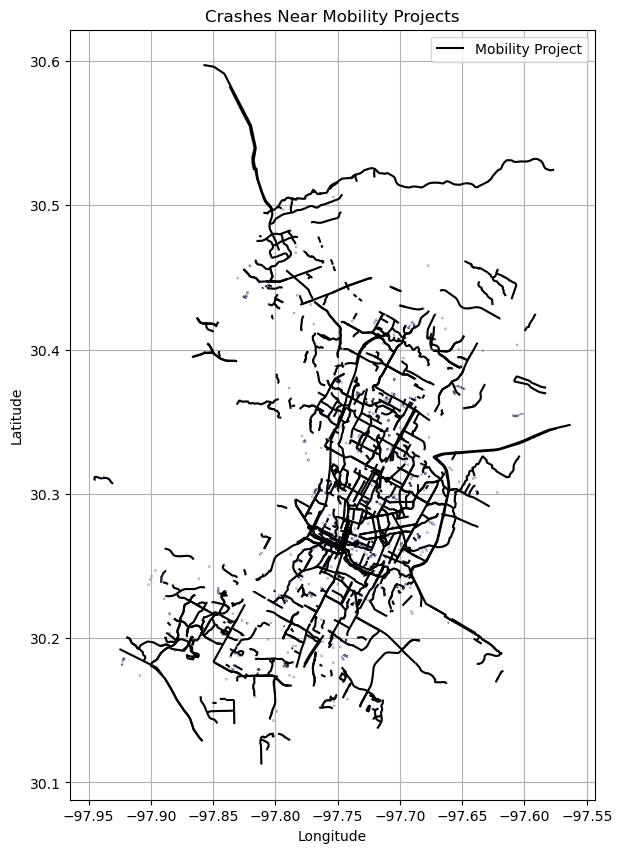

In [513]:
# Plot the mobility projects and crashes on a static map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered geometries (mobility projects)
buffered_moped_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1, alpha=0.15, label='Mobility Project Buffers')

# Plot the original line geometries (mobility projects)
gdf_moped.plot(ax=ax, color='black', label='Mobility Project')

# Plot the crash data points
# crashes_near_projects.plot(ax=ax, color='red', markersize=5, label='Crashes within Buffer')

# Enhance the plot with titles and legend
ax.set_title('Crashes Near Mobility Projects')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

In [514]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191422 entries, 1 to 415627
Data columns (total 24 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   crash_id                               191422 non-null  int64              
 1   crash_fatal_fl                         191422 non-null  object             
 2   crash_date                             191422 non-null  object             
 3   rpt_latitude                           14331 non-null   float64            
 4   rpt_longitude                          14331 non-null   float64            
 5   road_constr_zone_fl                    191422 non-null  object             
 6   latitude                               191422 non-null  float64            
 7   longitude                              191422 non-null  float64            
 8   tot_injry_cnt                          191422 non-null  float64            
 9 

In [515]:
crashes_near_projects.head()

,crash_id,crash_fatal_fl,crash_date,rpt_latitude,rpt_longitude,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,...,project_id,project_component_id,geometry_right,line_geometry,substantial_completion_date,substantial_completion_date_estimated,completion_date,completion_end_date,component_name,crash_project_component_id
1,19924404,N,2023-12-15,30.33031,-97.62485,N,30.330687,-97.623982,0.0,0.0,...,1307,1697.0,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279...",2014-05-01 05:00:00+00:00,NaT,NaT,NaT,Highway,19924404-1307-1697.0
9,19934149,N,2023-12-15,30.32510,-97.67200,N,30.325649,-97.673428,0.0,0.0,...,1307,1697.0,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279...",2014-05-01 05:00:00+00:00,NaT,NaT,NaT,Highway,19934149-1307-1697.0
56,19627431,N,2023-06-28,NaN,NaN,N,30.328519,-97.655276,0.0,0.0,...,1307,1697.0,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279...",2014-05-01 05:00:00+00:00,NaT,NaT,NaT,Highway,19627431-1307-1697.0
253,19923511,N,2023-12-15,NaN,NaN,N,30.334545,-97.607586,0.0,0.0,...,1307,1697.0,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279...",2014-05-01 05:00:00+00:00,NaT,NaT,NaT,Highway,19923511-1307-1697.0
391,19935719,N,2023-12-21,30.34292,-97.58479,N,30.343729,-97.582206,0.0,0.0,...,1307,1697.0,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279...",2014-05-01 05:00:00+00:00,NaT,NaT,NaT,Highway,19935719-1307-1697.0


In [516]:
# Writing to csv for project-type level analysis
crashes_near_projects.to_csv('crashes_near_projects.csv')

# Analysis

In [463]:
# Converting crash date to datetime format
crashes_near_projects['crash_date'] = pd.to_datetime(crashes_near_projects['crash_date']).dt.tz_localize('UTC', nonexistent='NaT', ambiguous='NaT')

In [464]:
# Converting crash date to datetime format
crashes_near_projects['crash_date'] = pd.to_datetime(crashes_near_projects['crash_date']).dt.tz_convert('UTC')

In [465]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191422 entries, 1 to 415627
Data columns (total 23 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   crash_id                               191422 non-null  int64              
 1   crash_fatal_fl                         191422 non-null  object             
 2   crash_date                             191422 non-null  datetime64[ns, UTC]
 3   rpt_latitude                           14331 non-null   float64            
 4   rpt_longitude                          14331 non-null   float64            
 5   road_constr_zone_fl                    191422 non-null  object             
 6   latitude                               191422 non-null  float64            
 7   longitude                              191422 non-null  float64            
 8   tot_injry_cnt                          191422 non-null  float64            
 9 

In [466]:
# Dropping columns
crashes_near_projects.drop(columns=['rpt_latitude', 
                                    'rpt_longitude', 
                                    'substantial_completion_date_estimated', 
                                    'completion_date', 
                                    'completion_end_date'], inplace=True)

In [467]:
# Re-arranging columns
# First column is the unique identifier for each observation
crashes_near_projects.insert(0, 'crash_project_component_id', crashes_near_projects.pop('crash_project_component_id'))

# moped_component_id
crashes_near_projects.insert(2, 'moped_component_id', crashes_near_projects.pop('moped_component_id'))

# crash_date
crashes_near_projects.insert(4, 'crash_date', crashes_near_projects.pop('crash_date'))

# project compoenent ID
crashes_near_projects.insert(3, 'project_component_id', crashes_near_projects.pop('project_component_id'))

# Substantial completion date
crashes_near_projects.insert(5, 'substantial_completion_date', crashes_near_projects.pop('substantial_completion_date'))


In [468]:
# Creating a binary version of the fatality column
crashes_near_projects['crash_fatal_binary'] = crashes_near_projects['crash_fatal_fl'].apply(lambda x: 1 if x == "Y" else 0)
crashes_near_projects.pop('crash_fatal_fl')
crashes_near_projects.insert(4, 'crash_fatal_binary', crashes_near_projects.pop('crash_fatal_binary'))

In [469]:
crashes_near_projects.head()

,crash_project_component_id,crash_id,moped_component_id,project_component_id,crash_fatal_binary,substantial_completion_date,crash_date,road_constr_zone_fl,latitude,longitude,tot_injry_cnt,death_cnt,est_comp_cost,geometry_left,index_right,project_id,geometry_right,line_geometry
1,19924404-1307-1697.0,19924404,713,1697.0,0,2014-05-01 05:00:00+00:00,2023-12-15 00:00:00+00:00,N,30.330687,-97.623982,0.0,0.0,306000.00,POINT (-97.62398 30.33069),1749,1307,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279..."
9,19934149-1307-1697.0,19934149,713,1697.0,0,2014-05-01 05:00:00+00:00,2023-12-15 00:00:00+00:00,N,30.325649,-97.673428,0.0,0.0,102000.00,POINT (-97.67343 30.32565),1749,1307,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279..."
56,19627431-1307-1697.0,19627431,713,1697.0,0,2014-05-01 05:00:00+00:00,2023-06-28 00:00:00+00:00,N,30.328519,-97.655276,0.0,0.0,153000.00,POINT (-97.65528 30.32852),1749,1307,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279..."
253,19923511-1307-1697.0,19923511,713,1697.0,0,2014-05-01 05:00:00+00:00,2023-12-15 00:00:00+00:00,N,30.334545,-97.607586,0.0,0.0,102000.00,POINT (-97.60759 30.33454),1749,1307,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279..."
391,19935719-1307-1697.0,19935719,713,1697.0,0,2014-05-01 05:00:00+00:00,2023-12-21 00:00:00+00:00,N,30.343729,-97.582206,0.0,0.0,51000.00,POINT (-97.58221 30.34373),1749,1307,"MULTILINESTRING ((-97.67333 30.32557, -97.6686...","MULTILINESTRING ((627540.019 3355607.639, 6279..."


In [470]:
crashes_near_projects['crash_fatal_binary'].value_counts()

crash_fatal_binary
0    190630
1       792
Name: count, dtype: int64

In [471]:
crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191422 entries, 1 to 415627
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   crash_project_component_id   191422 non-null  object             
 1   crash_id                     191422 non-null  int64              
 2   moped_component_id           191422 non-null  int64              
 3   project_component_id         191422 non-null  float64            
 4   crash_fatal_binary           191422 non-null  int64              
 5   substantial_completion_date  191422 non-null  datetime64[ns, UTC]
 6   crash_date                   191422 non-null  datetime64[ns, UTC]
 7   road_constr_zone_fl          191422 non-null  object             
 8   latitude                     191422 non-null  float64            
 9   longitude                    191422 non-null  float64            
 10  tot_injry_cnt                191422 n

In [472]:
# Creating indicator variables for crash occuring pre and post completion of mobility project
crashes_near_projects.insert(7, 'crash_pre_completion', crashes_near_projects['crash_date'] < crashes_near_projects['substantial_completion_date'])
crashes_near_projects.insert(8, 'crash_post_completion', crashes_near_projects['crash_date'] > crashes_near_projects['substantial_completion_date'])

In [473]:
# Creating time difference variables
crashes_near_projects.insert(9, 'crash_project_date_diff', crashes_near_projects['substantial_completion_date'] - crashes_near_projects['crash_date'])

In [474]:
# Converting estimated comp cost to float format
crashes_near_projects['est_comp_cost'] = crashes_near_projects['est_comp_cost'].map(lambda x: float(x))

crashes_near_projects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191422 entries, 1 to 415627
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   crash_project_component_id   191422 non-null  object             
 1   crash_id                     191422 non-null  int64              
 2   moped_component_id           191422 non-null  int64              
 3   project_component_id         191422 non-null  float64            
 4   crash_fatal_binary           191422 non-null  int64              
 5   substantial_completion_date  191422 non-null  datetime64[ns, UTC]
 6   crash_date                   191422 non-null  datetime64[ns, UTC]
 7   crash_pre_completion         191422 non-null  bool               
 8   crash_post_completion        191422 non-null  bool               
 9   crash_project_date_diff      191422 non-null  timedelta64[ns]    
 10  road_constr_zone_fl          191422 n

In [475]:
# Function to calculate duration in years
def calculate_duration(df, date_col1, date_col2):
    duration = (df[date_col2] - df[date_col1]).dt.total_seconds() / (365.25 * 24 * 3600)
    return duration

crashes_near_projects['pre_completion_duration'] = crashes_near_projects['crash_pre_completion'] * calculate_duration(crashes_near_projects, 'crash_date', 'substantial_completion_date')
crashes_near_projects['post_completion_duration'] = crashes_near_projects['crash_post_completion'] * calculate_duration(crashes_near_projects, 'substantial_completion_date', 'crash_date')

pre_completion_stats = crashes_near_projects[crashes_near_projects['crash_pre_completion'] == True].groupby('moped_component_id').agg({
    'crash_id': 'count',
    'pre_completion_duration': 'sum',
    'crash_fatal_binary': 'sum',
    'tot_injry_cnt': 'sum',
    'death_cnt': 'sum',
    'est_comp_cost': 'sum'
}).rename(columns={'crash_id': 'pre_crash_count',
                   'crash_fatal_binary': 'pre_fatal_crash_count',
                   'tot_injry_cnt': 'pre_total_injury_count',
                   'death_cnt': 'pre_total_death_count',
                   'est_comp_cost': 'pre_est_comp_cost'}).reset_index()

post_completion_stats = crashes_near_projects[crashes_near_projects['crash_post_completion'] == True].groupby('moped_component_id').agg({
    'crash_id': 'count',
    'post_completion_duration': 'sum',
    'crash_fatal_binary': 'sum',
    'tot_injry_cnt': 'sum',
    'death_cnt': 'sum',
    'est_comp_cost': 'sum'
}).rename(columns={'crash_id': 'post_crash_count',
                   'crash_fatal_binary': 'post_fatal_crash_count',
                   'tot_injry_cnt': 'post_total_injury_count',
                   'death_cnt': 'post_total_death_count',
                   'est_comp_cost': 'post_est_comp_cost'}).reset_index()


# Merging
annualized_statistics = pre_completion_stats.merge(post_completion_stats, on='moped_component_id', how='outer').fillna(0)

# Calculating annualized statistics
# Crash rate
annualized_statistics['pre_annualized_crash_rate'] = annualized_statistics['pre_crash_count'] / annualized_statistics['pre_completion_duration']
annualized_statistics['post_annualized_crash_rate'] = annualized_statistics['post_crash_count'] / annualized_statistics['post_completion_duration']

# Fatality
annualized_statistics['pre_annualized_fatal_crash_rate'] = annualized_statistics['pre_fatal_crash_count'] / annualized_statistics['pre_completion_duration']
annualized_statistics['post_annualized_fatal_crash_rate'] = annualized_statistics['post_fatal_crash_count'] / annualized_statistics['post_completion_duration']

# Injury count
annualized_statistics['pre_annualized_injury_rate'] = annualized_statistics['pre_total_injury_count'] / annualized_statistics['pre_completion_duration']
annualized_statistics['post_annualized_injury_rate'] = annualized_statistics['post_total_injury_count'] / annualized_statistics['post_completion_duration']

# Death count
annualized_statistics['pre_annualized_death_rate'] = annualized_statistics['pre_total_death_count'] / annualized_statistics['pre_completion_duration']
annualized_statistics['post_annualized_death_rate'] = annualized_statistics['post_total_death_count'] / annualized_statistics['post_completion_duration']

# Estimated cost
annualized_statistics['pre_annualized_cost'] = annualized_statistics['pre_est_comp_cost'] / annualized_statistics['pre_completion_duration']
annualized_statistics['post_annualized_cost'] = annualized_statistics['post_est_comp_cost'] / annualized_statistics['post_completion_duration']

In [476]:
# Getting completion date for each moped component id
completion_dates = crashes_near_projects.groupby('moped_component_id')['substantial_completion_date'].first().reset_index()

# Merging into the annualized crash rate DataFrame
annualized_statistics = annualized_statistics.merge(completion_dates, on='moped_component_id', how='left')

In [477]:
annualized_statistics = annualized_statistics[['moped_component_id', 
                                               'substantial_completion_date', 
                                               'pre_annualized_crash_rate', 
                                               'post_annualized_crash_rate',
                                               'pre_annualized_fatal_crash_rate',
                                               'post_annualized_fatal_crash_rate',
                                               'pre_annualized_injury_rate',
                                               'post_annualized_injury_rate',
                                               'pre_annualized_death_rate',
                                               'post_annualized_death_rate',
                                               'pre_annualized_cost',
                                               'post_annualized_cost'
                                               ]]

In [478]:
annualized_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   moped_component_id                2035 non-null   int64              
 1   substantial_completion_date       2035 non-null   datetime64[ns, UTC]
 2   pre_annualized_crash_rate         1839 non-null   float64            
 3   post_annualized_crash_rate        1437 non-null   float64            
 4   pre_annualized_fatal_crash_rate   1839 non-null   float64            
 5   post_annualized_fatal_crash_rate  1437 non-null   float64            
 6   pre_annualized_injury_rate        1839 non-null   float64            
 7   post_annualized_injury_rate       1437 non-null   float64            
 8   pre_annualized_death_rate         1839 non-null   float64            
 9   post_annualized_death_rate        1437 non-null   float64      

In [479]:
# Creating difference columns between pre and post
annualized_statistics.insert(4, 'delta_crash_rate', annualized_statistics['post_annualized_crash_rate']  - annualized_statistics['pre_annualized_crash_rate'])
annualized_statistics.insert(7, 'delta_fatal_crash_rate', annualized_statistics['post_annualized_fatal_crash_rate']  - annualized_statistics['pre_annualized_fatal_crash_rate'])
annualized_statistics.insert(10, 'delta_injury_rate', annualized_statistics['post_annualized_injury_rate']  - annualized_statistics['pre_annualized_injury_rate'])
annualized_statistics.insert(13, 'delta_death_rate', annualized_statistics['post_annualized_death_rate']  - annualized_statistics['pre_annualized_death_rate'])
annualized_statistics.insert(16, 'delta_comp_cost', annualized_statistics['post_annualized_cost']  - annualized_statistics['pre_annualized_cost'])


In [480]:
annualized_statistics

,moped_component_id,substantial_completion_date,pre_annualized_crash_rate,post_annualized_crash_rate,delta_crash_rate,pre_annualized_fatal_crash_rate,post_annualized_fatal_crash_rate,delta_fatal_crash_rate,pre_annualized_injury_rate,post_annualized_injury_rate,delta_injury_rate,pre_annualized_death_rate,post_annualized_death_rate,delta_death_rate,pre_annualized_cost,post_annualized_cost,delta_comp_cost
0,2,2022-10-10 05:00:00+00:00,0.119537,NaN,NaN,0.0,NaN,NaN,0.039846,NaN,NaN,0.0,NaN,NaN,17412.542784,NaN,NaN
1,3,2022-10-10 05:00:00+00:00,0.167992,NaN,NaN,0.0,NaN,NaN,0.111995,NaN,NaN,0.0,NaN,NaN,156960.694506,NaN,NaN
2,4,2022-10-10 05:00:00+00:00,0.159788,0.736701,0.576913,0.0,0.0,0.0,0.036315,0.736701,0.700385,0.0,0.0,0.0,45437.828003,171651.231196,126213.403193
3,5,2022-10-10 05:00:00+00:00,0.157995,0.736701,0.578705,0.0,0.0,0.0,0.022571,0.736701,0.714130,0.0,0.0,0.0,30583.347709,171651.231196,141067.883487
4,7,2024-02-20 06:00:00+00:00,0.136192,NaN,NaN,0.0,NaN,NaN,0.085120,NaN,NaN,0.0,NaN,NaN,31988.103006,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,2628,2018-05-01 05:00:00+00:00,NaN,0.513864,NaN,NaN,0.0,NaN,NaN,0.385398,NaN,NaN,0.0,NaN,NaN,142211.765051,NaN
2031,2629,2018-05-01 05:00:00+00:00,NaN,0.439112,NaN,NaN,0.0,NaN,NaN,0.292742,NaN,NaN,0.0,NaN,NaN,112998.246756,NaN
2032,2630,2018-05-01 05:00:00+00:00,NaN,0.468034,NaN,NaN,0.0,NaN,NaN,0.374427,NaN,NaN,0.0,NaN,NaN,130207.118221,NaN
2033,2631,2018-05-01 05:00:00+00:00,NaN,0.513864,NaN,NaN,0.0,NaN,NaN,0.385398,NaN,NaN,0.0,NaN,NaN,142211.765051,NaN


In [481]:
annualized_statistics.to_csv('annualized_statistics.csv', na_rep="NA", index=False)